<a href="https://colab.research.google.com/github/merge-ai/disentangling_conditional_gans/blob/master/Conditional_GAN_(cGAN)_on_Fashion_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Fashion MNIST Clothing Photo Dataset
#example of loading the fashion mnist dataset
from keras.datasets.fashion_mnist import load_data
#load the images into memory
(trainx, trainy), (testx, testy)= load_data()
#summarize the shape of the dataset
print('Train', trainx.shape, trainy.shape)
print('Test', testx.shape, testy.shape)

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


As you can see, loading the dataset and prints the shape of the input and output components of the train and test split images.

We can see that there are 60k examples in the training set and 10k in the test and that each image is a square of by 28 by 28 pixels

We can now plot some of the images from the training dataset using matplotlib.

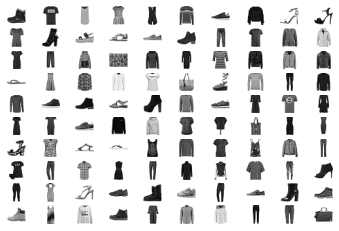

In [2]:
#plot the images of the datatset
from matplotlib import pyplot

#plot the images from the training dataset
for i in range(100):
  #define subplot
  pyplot.subplot(10,10, 1 + i)
  #turn off axis
  pyplot.axis('off')
  #plot raw pixel data
  pyplot.imshow(trainx[i], cmap= 'gray_r')
pyplot.show()

As you see, running the exmple creates a figure with a plot of 100 images from the MNIST training dataset, arranged in a 10x10 square.

Now we will use the images in the traijing dataset as a BASIS for training a GAN.
  *Specifically, the generator model will learn how to generate new plausible items of clothing using a discriminator that will try to distinguish between real images from the FASHION-MNIST training dataset.

#CONDITIONAL GAN FOR THE FASHION-MNIST
The best way to to design models in Keras that have multiple inputs (such as a conditional GAN) is by using the Functional API instead of the Sequential API using in a unconditonal GAN.

Starting with the discirminator model, a new second input is defined that takes an integer for the class label of the image. 
  *this has the effect of maing the input image **conditional** on the provided class label.

Next, the class label is then passed through an Embedding layer with a size of 50. (This means that each of the 10 classes within the dataset (0 through 9) will map to a different 50 element vector representation that will be learned by the discriminator model)


In [1]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
#example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding  #this is specifically for the conditional GAN model
from keras.layers import Concatenate  #used for the conditional gan model

#define standalone d_model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  #label input
  in_label= Input(shape=(1,))
  #embedding for categorical input 
  li= Embedding(n_classes, 50)(in_label)
  #scale up to imahe dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li= Dense(n_nodes)(li)
  #reshape to additional channel
  li= Reshape((in_shape[0], in_shape[1], 1))(li)
  #image input
  in_image= Input(shape= in_shape)
  #concat label as a channel
  merge= Concatenate()([in_image, li])
  #downsample
  fe= Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe= LeakyReLU(alpha= 0.2)(fe)
  #downsample
  fe= Conv2D(128,(3,3), strides=(2,2), padding='same')(fe)
  fe= LeakyReLU(alpha=0.2)(fe)
  #flatten feature maps
  fe= Flatten()(fe)
  #dropout
  fe= Dropout(0.4)(fe)
  #output
  out_layer= Dense(1, activation='sigmoid')(fe)
  #define model
  model= Model([in_image, in_label], out_layer)
  #compile model
  opt= Adam(lr= 0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer= opt, metrics= ['accuracy'])
  return model

#define standalone generator model
def define_generator(latent_dim, n_classes=10):
  #label input
  in_label= Input(shape=(1,))
  #embedding for categorical input 
  li= Embedding(n_classes, 50)(in_label)
  #linear multiplication
  n_nodes= 7 * 7
  li= Dense(n_nodes)(li)
  #reshape to additional channel
  li= Reshape((7,7,1))(li)
  #image generator input
  in_lat= Input(shape=(latent_dim,))
  #foundation for 7 x 7 image
  n_nodes= 128 * 7 * 7
  gen= Dense(n_nodes)(in_lat)
  gen= LeakyReLU(alpha=0.2)(gen)
  gen= Reshape((7,7,128))(gen)
  #merge image gen and label input
  merge= Concatenate()([gen, li])
  #upsample to 14x14
  gen= Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')(merge)
  gen= LeakyReLU(alpha=0.2)(gen)
  #upsample to 28x28
  gen= Conv2DTranspose(128,(4,4), strides= (2,2), padding='same')(gen)
  gen= LeakyReLU(alpha=0.2)(gen)
  #output
  out_layer= Conv2D(1, (7,7), activation= 'tanh', padding= 'same')(gen)
  #define model
  model= Model([in_lat, in_label], out_layer)
  return model

#define our gan model
def define_gan(g_model, d_model):
  #make weights in the discriminator non trainable
  d_model.trainable= False
  #get noise and label inputs from the generator model
  gen_noise, gen_label= g_model.input
  #get imge output from the generatormodel
  gen_output= g_model.output
  #connect image output and label input from the generatoras inputs to the discriminator
  gan_output= d_model([gen_output, gen_label])
  #define gan model as taking the noise and label and outputting a classification
  model= Model([gen_noise, gen_label], gan_output)
  #compile model
  opt= Adam(lr= 0.0002, beta_1= 0.5)
  model.compile(loss= 'binary_crossentropy', optimizer= opt)
  return model


#load fashion mnist images
def load_real_samples():
  #load dataset
  (trainx, trainy), (_,_)= load_data()
  #expand to 3d, (add channels)
  X= expand_dims(trainx, axis = -1)
  #convert from int to float
  X= X.astype('float32')
  #scale from [0,255] tp [-1, 1]
  X= (X - 127.5) / 127.5
  return [X, trainy]

#select real samples
def generate_real_samples(dataset, n_samples):
  #split into images and labels
  images, labels= dataset
  #choose random instances
  ix= randint(0, images.shape[0], n_samples)
  #select images and labels
  X, labels= images[ix], labels[ix]
  #generate class labels
  y= ones((n_samples, 1))
  return [X, labels], y

#generate points in latent space
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  #generate points in the latent space
  x_input= randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  z_input= x_input.reshape(n_samples, latent_dim)
  #generate labels
  labels= randint(0, n_classes, n_samples)
  return [z_input, labels]

#use the generator to generate fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  #generate points in the latent space
  z_input, labels_input= generate_latent_points(latent_dim, n_samples)
  #predict outputs
  images= generator.predict([z_input, labels_input])
  #create class labels
  y= zeros((n_samples, 1))
  return [images, labels_input], y

#train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch= 128):
  bat_per_epo= int(dataset[0].shape[0] / n_batch)
  half_batch= int(n_batch / 2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected 'real' samples
      [X_real, labels_real], y_real= generate_real_samples(dataset, half_batch)
      #update discrimnator model weights
      d_loss1, _= d_model.train_on_batch([X_real, labels_real], y_real)
      #generate fake samples
      [X_fake, labels], y_fake= generate_fake_samples(g_model, latent_dim, half_batch)
      #update discriminator model weights
      d_loss2, _= d_model.train_on_batch([X_fake, labels], y_fake)
      #prepare points in latent space as input for the generator
      [z_input, labels_input]= generate_latent_points(latent_dim, n_batch)
      #create inverted labels for the fake samples
      y_gan= ones((n_batch, 1))
      #update the generator via the discriminators error
      g_loss= gan_model.train_on_batch([z_input, labels_input], y_gan)
      #summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
            (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
  #save the generator model
  g_model.save('cgan_generator.h5')

#size of the latent space
latent_dim= 100
#create the discriminator
d_model= define_discriminator()
#create the generator
g_model= define_generator(latent_dim)
#create the gan
gan_model= define_gan(g_model, d_model)
#load image data
dataset= load_real_samples()
#train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.686, d2=0.696 g=0.691
>1, 2/468, d1=0.606, d2=0.701 g=0.686
>1, 3/468, d1=0.544, d2=0.710 g=0.677
>1, 4/468, d1=0.493, d2=0.724 g=0.664
>1, 5/468, d1=0.433, d2=0.745 g=0.646


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>90, 150/468, d1=0.632, d2=0.707 g=0.797
>90, 151/468, d1=0.712, d2=0.682 g=0.807
>90, 152/468, d1=0.684, d2=0.693 g=0.788
>90, 153/468, d1=0.683, d2=0.666 g=0.825
>90, 154/468, d1=0.675, d2=0.636 g=0.791
>90, 155/468, d1=0.715, d2=0.678 g=0.780
>90, 156/468, d1=0.697, d2=0.663 g=0.773
>90, 157/468, d1=0.732, d2=0.686 g=0.788
>90, 158/468, d1=0.679, d2=0.672 g=0.795
>90, 159/468, d1=0.660, d2=0.688 g=0.799
>90, 160/468, d1=0.673, d2=0.653 g=0.817
>90, 161/468, d1=0.723, d2=0.660 g=0.795
>90, 162/468, d1=0.657, d2=0.661 g=0.810
>90, 163/468, d1=0.637, d2=0.683 g=0.789
>90, 164/468, d1=0.670, d2=0.655 g=0.779
>90, 165/468, d1=0.692, d2=0.713 g=0.794
>90, 166/468, d1=0.718, d2=0.622 g=0.823
>90, 167/468, d1=0.668, d2=0.649 g=0.825
>90, 168/468, d1=0.747, d2=0.620 g=0.787
>90, 169/468, d1=0.659, d2=0.644 g=0.797
>90, 170/468, d1=0.650, d2=0.641 g=0.766
>90, 171/468, d1=0.733, d2=0.700 g=0.769
>90, 172/468, d1=0.684, d2=0.674 g=0.758
>90, 1

#CONDITIONAL CLOTHING GENERATION
Now we can used the trained generator model from above to conditionally generate new photos of items of clothing.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


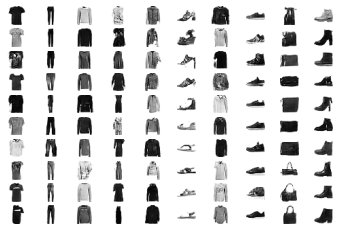

In [5]:
#example of loading thegenrator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

#generate points in atent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  #generate points in the latent space
  x_input= randn(latent_dim * n_samples)
  #reshape into a batch of inputs for the network
  z_input= x_input.reshape(n_samples, latent_dim)
  #generate labels
  labels= randint(0, n_classes, n_samples)
  return [z_input, labels]

#create a save a plot of generated images
def save_plot(examples, n):
  #plot images
  for i in range(n * n):
    #define subplot 
    pyplot.subplot(n, n, 1 + i)
    #turn off axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap= 'gray_r')
  pyplot.show()

#load model
model= load_model('cgan_generator.h5')
#generate images
latent_points, labels= generate_latent_points(100, 100)
#specify labels
labels= asarray([x for _ in range(10) for x in range(10)])
#generate images
x= model.predict([latent_points, labels])
#scale from [-1, 1] to [0,1]
x= (x + 1) / 2.0
#plot the result
save_plot(x, 10)